In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import skimage

In [2]:
print('loading gt')
# gt = skimage.measure.label(np.array(Image.open(Path('images/texmos2.s512.tiff')).convert('L')), background=-1, connectivity=1)
gt = skimage.measure.label(np.array(Image.open(Path('images/texmos3.s512.tiff')).convert('L')), background=-1, connectivity=1)
print('loading logits')
logits = np.load('tmp/logits.npy')
print('loading superpixels')
superpixels = np.load('tmp/superpixels.npy')
rsuperpixels = np.array(Image.fromarray(superpixels.astype(np.uint16)).resize(gt.shape[::-1], Image.Resampling.NEAREST))

loading gt
loading logits
loading superpixels


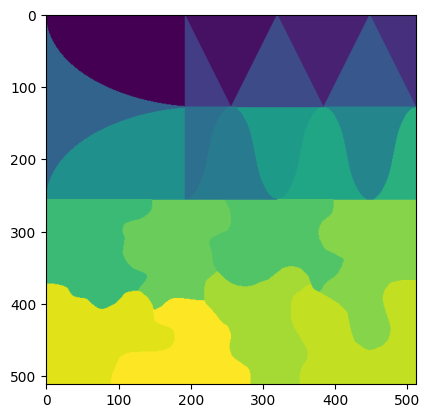

In [3]:
plt.figure()
plt.imshow(gt)

## compute upper bound of superpixel merging performance

In [4]:
ious = []
unique_superpixels = np.unique(rsuperpixels)
for gt_label in np.unique(gt):
    gt_mask = (gt == gt_label)  # ground truth mask
    gt_mask_size = np.sum(gt_mask)
    scores = []
    for sp_label in unique_superpixels:
        sp_mask = (rsuperpixels == sp_label)  # superpixel mask
        intersection = np.logical_and(gt_mask, sp_mask)
        inside = np.sum(intersection)
        outside = np.sum(sp_mask) - inside
        if outside == 0:
            scores.append(np.inf)
        else:
            scores.append(inside / outside)

    # argsort scores
    sorted_indices = reversed(np.argsort(scores, stable=True))
    mask_so_far = np.zeros_like(gt_mask)
    current_iou = 0
    for next_best_ind in sorted_indices:
        if scores[next_best_ind] < current_iou:
            break
        sp_label = unique_superpixels[next_best_ind]
        sp_mask = (rsuperpixels == sp_label)
        mask_so_far = np.logical_or(mask_so_far, sp_mask)
        intersection = np.logical_and(mask_so_far, gt_mask)
        union = np.logical_or(mask_so_far, gt_mask)
        current_iou = np.sum(intersection) / np.sum(union)
    ious.append(current_iou)
    print('gt label:', gt_label, 'iou:', current_iou, end='\r')
print('mean iou:', np.mean(ious))
# image ind = 0
# mean iou: 0.82872058885878264025974036 (c1 logits)
# mean iou: 0.83199464647340552727272737 (logits) <- logits without c1 seem to better
# image ind = 1
# mean iou: 0.942971797204369514006238 (logits)

mean iou: 0.942971797204369514006238


## compute sam2 performance without filtering any logit map

In [ ]:
sam2_ious = []
for gt_label in np.unique(gt):
    gt_mask = (gt == gt_label)  # ground truth mask
    best_iou = 0
    for logit_channel in range(len(logits)):
        resized_logit = skimage.transform.resize(logits[logit_channel], gt.shape, order=1, anti_aliasing=False)
        intersection = np.logical_and(gt_mask, resized_logit > 0).sum()
        if intersection == 0:
            continue
        union = np.logical_or(gt_mask, resized_logit > 0).sum()
        current_iou = intersection / union  
        if current_iou > best_iou:
            best_iou = current_iou
    sam2_ious.append(best_iou)
    print('gt label:', gt_label, 'iou:', current_iou, end='\r')
print('mean iou:', np.mean(sam2_ious))
# image ind = 0
# mean iou: 0.61296344954377364343434343124 (with c1 logits)
# mean iou: 0.7757326059054758940298507436 @ 20 (with c1 logits)
# mean iou: 0.7566465898412257998905508655 @ 20 (without c1 logits)
# image ind = 1
# mean iou: 0.8729525485598967938300349255 @ 20 (logits)
# mean iou: 0.8703681061350197671711067255 (logits)





mean iou: 0.8703681061350197671711067255


### what happens if we reconstruct sam masks from the superpixels and run the evaluation again? it works slightly better!

In [6]:
approx_logits = []

for i in range(len(logits)):
    logit_mask = logits[i] > 0

    overlapping_superpixels = np.unique(superpixels[logit_mask])
    overlapping_superpixels_scores = []
    for overlapping_superpixel in overlapping_superpixels:
        mask = (superpixels == overlapping_superpixel)
        intersection = np.logical_and(mask, logit_mask)
        inside = np.sum(intersection)
        outside = np.sum(mask) - inside
        if outside == 0:
            overlapping_superpixels_scores.append(np.inf)
        else:
            overlapping_superpixels_scores.append(inside / outside)

    # argsort scores
    sorted_indices = reversed(np.argsort(overlapping_superpixels_scores, stable=True))
    mask_so_far = np.zeros_like(logit_mask)
    current_iou = 0
    for next_best_ind in sorted_indices:
        if overlapping_superpixels_scores[next_best_ind] < current_iou:
            break
        sp_label = overlapping_superpixels[next_best_ind]
        sp_mask = (superpixels == sp_label)
        mask_so_far = np.logical_or(mask_so_far, sp_mask)
        intersection = np.logical_and(mask_so_far, logit_mask)
        union = np.logical_or(mask_so_far, logit_mask)
        current_iou = np.sum(intersection) / np.sum(union)

    approx_logits.append(mask_so_far)
    print('logit ind:', i, 'iou:', current_iou, end='\r')
approx_logits = np.array(approx_logits)


In [ ]:
sam2_ious_reconstructed = []
for gt_label in np.unique(gt):
    gt_mask = (gt == gt_label)  # ground truth mask
    best_iou = 0
    for logit_channel in range(len(approx_logits)):
        resized_logit = skimage.transform.resize(approx_logits[logit_channel], gt.shape, order=0, anti_aliasing=False)
        intersection = np.logical_and(gt_mask, resized_logit > 0).sum()
        if intersection == 0:
            continue
        union = np.logical_or(gt_mask, resized_logit > 0).sum()
        current_iou = intersection / union  
        if current_iou > best_iou:
            best_iou = current_iou
    sam2_ious_reconstructed.append(best_iou)
    print('gt label:', gt_label, 'iou:', current_iou, end='\r')
print('mean iou:', np.mean(sam2_ious_reconstructed))
# image ind = 0
# mean iou: 0.6201104374798151025641025644 (with c1 logits)
# mean iou: 0.786330471354893614189303152 @ 20 (with c1 logits)
# mean iou: 0.7798740362075728063492063576 @ 20 (without c1 logits)
# image ind = 1
# mean iou: 0.890725424797748622346368728 @ 20 (logits)
# mean iou: 0.889056189787779305477367728 (logits)


mean iou: 0.889056189787779305477367728
